In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import json
import csv
import os
from bmtool.util.util import load_nodes_from_config

from analysis import plot, utils, process # imoporting analysis module enables import from model folder
from build_input import get_populations, get_stim_cycle, t_start, on_time, off_time

%matplotlib inline

TRIAL_NAME = "baseline_r41"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)
INPUT_PATH = os.path.join('..', 'M1Focus', 'input')

### Load data

In [2]:
stimulus_type, config = utils.stimulus_type_from_trial_name(TRIAL_NAME)
isbaseline = stimulus_type == 'baseline' or stimulus_type == 'const'

spike_file = os.path.join('..', 'Analysis', TRIAL_PATH, 'spikes.h5')
config_file = os.path.join('..', 'M1Focus', config)

pop_color = plot.pop_color
pop_names = plot.pop_names

network_name = 'cortex'
spikes_df = utils.load_spikes_to_df(spike_file, network_name)

node_df = load_nodes_from_config(config_file)[network_name]
pop_ids = get_populations(node_df, pop_names, only_id=True)

### Spike Raster

In [3]:
result_config_file = 'config_no_STP.json' if 'no_STP' in TRIAL_NAME else config
with open(os.path.join('..', 'Analysis', TRIAL_PATH, result_config_file), 'r') as f:
    conf = json.load(f)
    t_stop = conf['run']['tstop'] / 1000

if not isbaseline:
    t_cycle, n_cycle = get_stim_cycle(on_time, off_time, t_start, t_stop)
    window = t_start + np.array([[0, on_time]])
    windows = (window + t_cycle * np.arange(n_cycle).reshape(n_cycle, 1))
else:
    windows = np.array([[t_start, t_stop]])

#### Sort cell IDs

In [4]:
if isbaseline:
#     group_ids = [node_df.sort_values('pos_z').index]  # mix populations
    group_ids = [node_df.loc[grp].sort_values('pos_z').index for grp in pop_ids.values()]  # separate populations
else:
    with open(os.path.join(INPUT_PATH, 'Assembly_ids.csv'), 'r') as f:
        assembly_ids = [np.array(list(map(int, row)), dtype='uint64') for row in csv.reader(f)]
    group_ids = assembly_ids[len(assembly_ids) // 2:]
    group_ids.append(sorted(set(node_df.index) - set(np.concatenate(group_ids))))

z_5A = 0.  # boundary between 5A and 5B
sorted_groups = [[], []] # differentiate 5B and 5A
for grp in group_ids:
    grp = np.asarray(grp)
    idx_5A = node_df.loc[grp, 'pos_z'] >= z_5A
    sorted_groups[0].append(grp[~idx_5A])
    sorted_groups[1].append(grp[idx_5A])

sorted_ids = pd.Series(-1, index=node_df.index)
for i, node_id in enumerate(np.concatenate(sum(sorted_groups, []))):
    sorted_ids[node_id] = i

node_df['sorted_id'] = sorted_ids
spikes_df['sorted_id'] = node_df.loc[spikes_df['node_ids'], 'sorted_id'].values

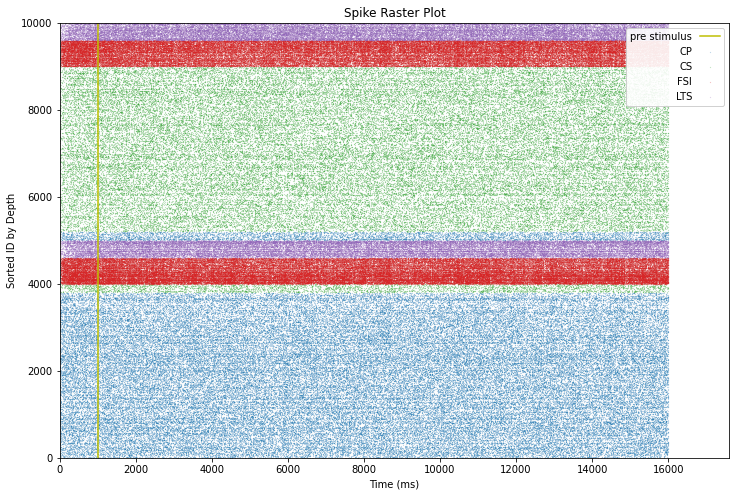

In [5]:
# %matplotlib notebook

spikes_df['pop_name'] = node_df.loc[spikes_df['node_ids'], 'pop_name'].values
pop_spike = get_populations(spikes_df, pop_names)

_, ax = plt.subplots(1, 1, figsize=(12, 8))
plot.raster(pop_spike, pop_color, id_column='sorted_id', s=0.01, ax=ax)
ax.axvline(t_start * 1000, color='y', label='pre stimulus')
if isbaseline:
    ax.set_ylabel('Sorted ID by Depth')
else:
    for win in windows:
        ax.axvline(win[0] * 1000, color='white', alpha=0.5)
        ax.axvline(win[1] * 1000, color='orange', alpha=0.5)
    ax.set_ylabel('Sorted ID by Assembly')
ax.legend(loc='upper right', framealpha=0.9, markerfirst=False)
ax.set_xlim([0, 1.1 * spikes_df['timestamps'].max()])
ax.set_ylim([node_df.index.min() - 1, node_df.index.max() + 1])
plt.show()

### Firing Rate

Firing rate: mean, std
CP: 1.9, 1.79
CS: 1.3, 1.37
FSI: 7.5, 6.02
LTS: 5, 5.93


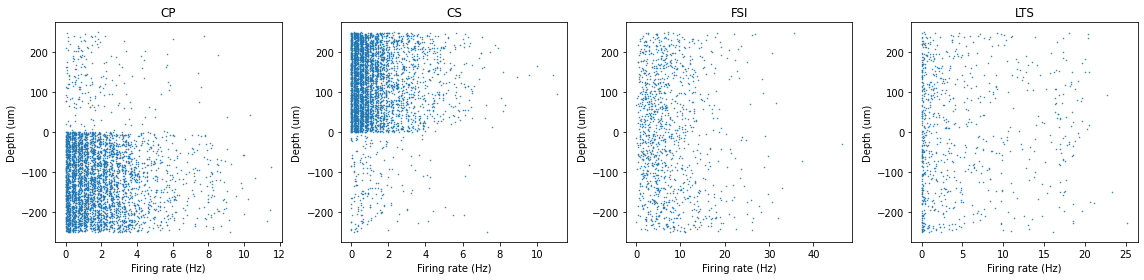

In [6]:
frs = process.firing_rate(spikes_df, num_cells=len(node_df), time_windows=windows)
pop_fr = {p: frs[nid] for p, nid in pop_ids.items()}

if not isbaseline:
    print('Stimulus on time: ')

print('Firing rate: mean, std')
for p, fr in pop_fr.items():
    print(f'{p}: {fr.mean():.3g}, {fr.std():.3g}')

_, axs = plt.subplots(1, len(pop_names), figsize=(4 * len(pop_names), 4))
for ax, p in zip(axs, pop_names):
    ax.plot(pop_fr[p], node_df.loc[pop_ids[p], 'pos_z'], '.', markersize=1)
    ax.set_xlabel('Firing rate (Hz)')
    ax.set_ylabel('Depth (um)')
    ax.set_title(p)
plt.tight_layout()
plt.show()

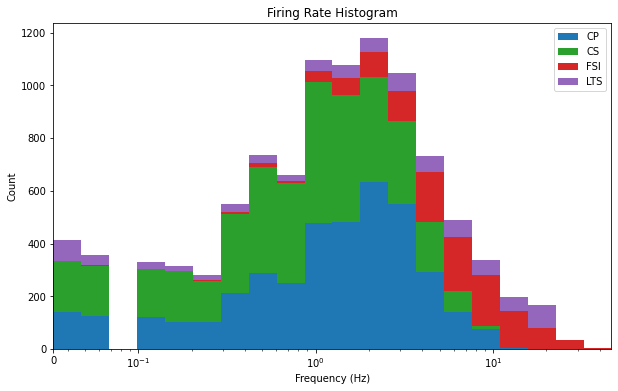

In [7]:
min_fr = 0.5 / process.total_duration(windows)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.firing_rate_histogram(pop_fr, pop_color, bins=20, min_fr=min_fr,
                      logscale=True, stacked=True, ax=ax)
plt.show()

### Population spike rate

In [8]:
fs = 2000.
time = np.array([0, 1000 * t_stop, 1000 / fs])
pop_rspk = {p: process.pop_spike_rate(spk['timestamps'], time) for p, spk in pop_spike.items()}

In [9]:
SAVE_PATH = os.path.join(TRIAL_PATH, 'spike_rate.h5')

with h5py.File(SAVE_PATH, 'w') as f:
    f.create_dataset('time', data=time)
    grp = f.create_group('populations')
    for p, rspk in pop_rspk.items():
        pop = grp.create_group(p)
        pop.create_dataset('data', data=rspk)
        pop.attrs['number'] = len(pop_ids[p])

### Calling plot functions directly

Plotting cortex spike raster


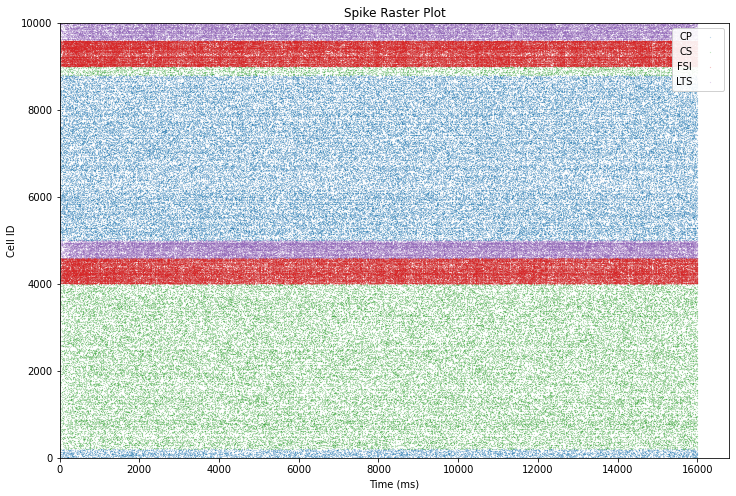

Firing rate: mean, std
CP: 1.9, 1.79
CS: 1.29, 1.36
FSI: 7.58, 6.05
LTS: 4.94, 5.89
Plotting firing rates


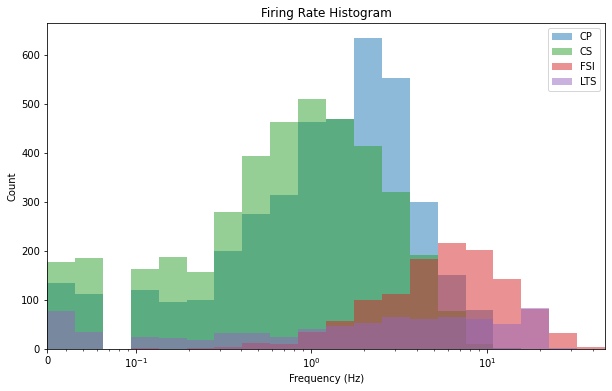

In [10]:
pop_spike = plot.plot(choose=1, spike_file=spike_file, config=config, figsize=(12, 8))

if not isbaseline:
    print('On average: ')
frs = plot.plot(choose=2, spike_file=spike_file, figsize=(10, 6))